In [68]:
import pandas as pd
vehicles=pd.read_csv("vehicle_sales.csv")
vehicles.drop_duplicates(inplace=True)
vehicles.dropna(inplace=True)
vehicles.drop('vin', axis=1, inplace=True)

vehicles.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [69]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472325 entries, 0 to 558836
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          472325 non-null  int64  
 1   make          472325 non-null  object 
 2   model         472325 non-null  object 
 3   trim          472325 non-null  object 
 4   body          472325 non-null  object 
 5   transmission  472325 non-null  object 
 6   state         472325 non-null  object 
 7   condition     472325 non-null  float64
 8   odometer      472325 non-null  float64
 9   color         472325 non-null  object 
 10  interior      472325 non-null  object 
 11  seller        472325 non-null  object 
 12  mmr           472325 non-null  float64
 13  sellingprice  472325 non-null  float64
 14  saledate      472325 non-null  object 
dtypes: float64(4), int64(1), object(10)
memory usage: 57.7+ MB


In [70]:
# Step 1: Remove timezone info like 'GMT-0800 (PST)'
vehicles['saledate'] = vehicles['saledate'].str.replace(r'GMT.*', '', regex=True)

# Step 2: Convert to datetime object
vehicles['saledate'] = pd.to_datetime(vehicles['saledate'], dayfirst=True, errors='coerce')

vehicles.sort_values(by='saledate', inplace=True)
vehicles.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
52310,2012,Chevrolet,Cruze,2LT,Sedan,automatic,sc,25.0,50457.0,white,black,the hertz corporation,9750.0,8900.0,2014-01-01 09:15:00
67886,2002,Ford,Focus,ZX5,Hatchback,automatic,sc,21.0,109475.0,white,gray,jd byrider/cnac,1950.0,1800.0,2014-01-01 09:15:00
70475,2012,Nissan,Altima,2.5 S,Sedan,automatic,sc,19.0,84325.0,blue,black,south carolina state credit union,8600.0,7300.0,2014-01-01 09:15:00
52753,2014,Chevrolet,Captiva Sport,LTZ Fleet,SUV,automatic,sc,28.0,34169.0,black,gray,enterprise veh exchange/rental,15800.0,15000.0,2014-01-01 09:15:00
69201,2013,Chevrolet,Cruze,1LT,Sedan,automatic,sc,41.0,55209.0,white,black,the hertz corporation,9900.0,9500.0,2014-01-01 09:15:00


In [76]:
# Group by SaleDate and Make, summing the 'sellingprice' column (sales revenue)
grouped = vehicles.groupby([
    vehicles['saledate'].dt.to_period('M').dt.to_timestamp(),  # group by month
    'make'  # group by brand
])['sellingprice'].sum().reset_index()

# Rename columns for clarity
grouped.rename(columns={'saledate': 'Date', 'make': 'Brand', 'sellingprice': 'Sales'}, inplace=True)
grouped.tail()

,Date,Brand,Sales
399,2015-07-01,Suzuki,12600.0
400,2015-07-01,Toyota,1271350.0
401,2015-07-01,Volkswagen,222100.0
402,2015-07-01,Volvo,62850.0
403,2015-07-01,smart,5750.0


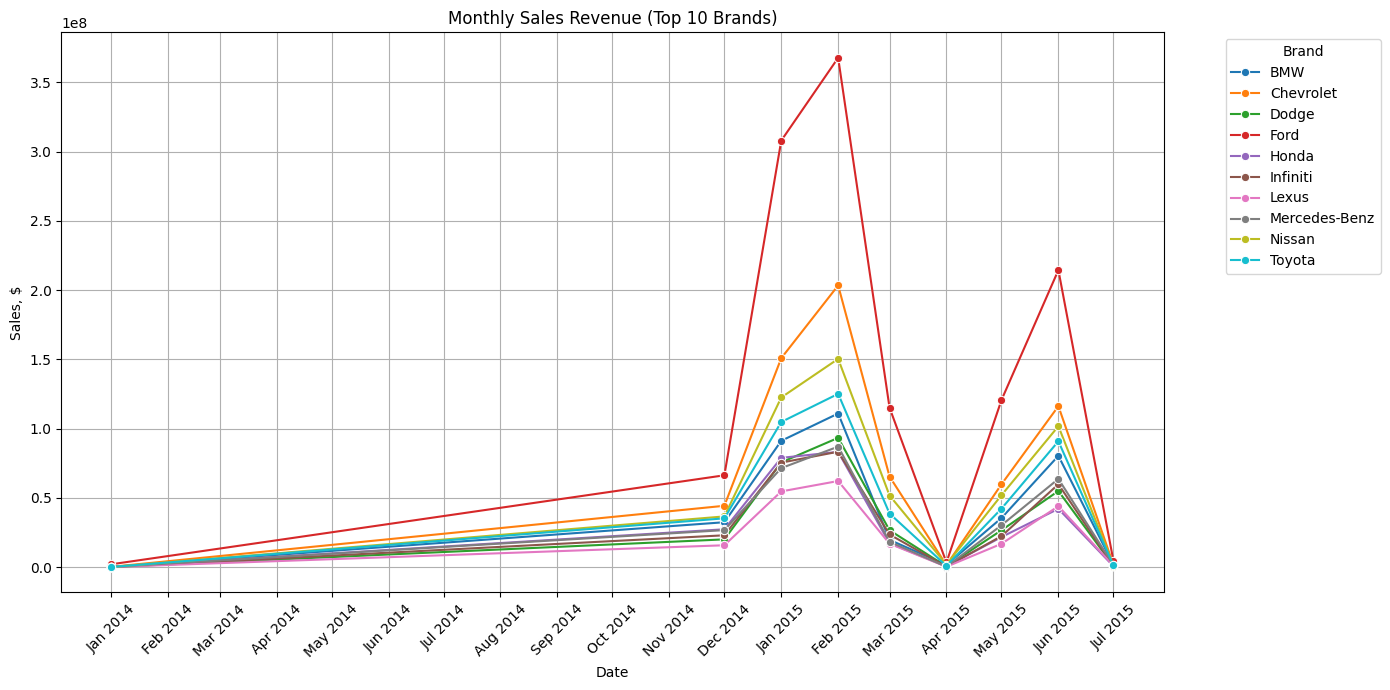

In [77]:
# 1. Get top 10 brands by total selling price
top_10_brands = (
    grouped.groupby('Brand')['Sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# 2. Filter grouped data to only include those brands
top_grouped = grouped[grouped['Brand'].isin(top_10_brands)]

# 3. Plot line chart
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(14, 7))

sns.lineplot(data=top_grouped, x='Date', y='Sales', hue='Brand', marker='o')

plt.title('Monthly Sales Revenue (Top 10 Brands)')
plt.xlabel('Date')
plt.ylabel('Sales, $')
# 👇 Force x-axis to show every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as Jan 2015

plt.xticks(rotation=45)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


1. Top Brands & Models Overall
Bar Chart: Top 10 brands by total revenue or quantity sold.

Bar Chart: Top 10 vehicle models.

1. Revenue Forecasting
Use Prophet or ARIMA to forecast sales for next 6 months.